<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><strong>Вывод:</strong></a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><strong>Обучение</strong></a></span><ul class="toc-item"><li><span><a href="#2.1.-TF-IDF" data-toc-modified-id="2.1.-TF-IDF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><strong>2.1. TF-IDF</strong></a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><strong>Вывод:</strong></a></span></li><li><span><a href="#Непосредственно-обучение:" data-toc-modified-id="Непосредственно-обучение:-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span><strong>Непосредственно обучение:</strong></a></span></li><li><span><a href="#Протестируем-лучшую-модель:" data-toc-modified-id="Протестируем-лучшую-модель:-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span><strong>Протестируем лучшую модель:</strong></a></span></li><li><span><a href="#2.2-Обучение-на-BERT" data-toc-modified-id="2.2-Обучение-на-BERT-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span><strong>2.2 Обучение на BERT</strong></a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`.
- Столбец *text* в нём содержит текст комментария,
- *toxic* — целевой признак.

Комментарии:
- Работу выполняю в **google colab**
- использую **BERT**

## Подготовка

In [ ]:
#Установка библиотеки transformers и др.для  GC
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost
    !pip install pytorch-transformers
    #!pip install transformers
    !pip install pytorch-pretrained-bert
    import transformers as ppb
    #gpu_info = !nvidia-smi
    #gpu_info = '\n'.join(gpu_info)
    #if gpu_info.find('failed') >= 0:
    #    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    #    print('and then re-execute this cell.')
    #else:
    #    print(gpu_info)

    print('Environment: Google Colab')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer,r2_score,f1_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from numpy.random import RandomState
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import time

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from pytorch_transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification

from tqdm import notebook, tqdm, trange
import re
import nltk
nltk.download('wordnet','stopwords','punkt','averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
#import lightgbm
#from gensim.models import Word2Vec
#from keras.preprocessing.sequence import pad_sequences

from IPython.display import clear_output
import io

import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

In [ ]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', sep=',', index_col=[0])
    #data=pd.read_csv('/content/toxic_comments.csv', sep=',', index_col=[0])
except:
    data=pd.read_csv('/datasets/toxic_comments.csv', sep=',', index_col=[0])
data.sort_index(inplace=True)
# Приведем все даенные в читаемый формат
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
#напишем функцию для исследования данных
def research(data, name, name_column, silent):
    print(f'Размер данных:      {data.shape}')
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    if not silent:
        print(f'Наличие пропусков:           {data.isna().sum().sum()}')
        print('\nПропущенные данные (в процентном соотношении):')
        print(round(data.isna().mean()*100).sort_values(ascending=False).head(13))
    print(f'\nПроверка структуры {name}:')
    print()
    data.info()
    print('\nСоотношение в целевом признаке:')
    print(data.toxic.value_counts()/data.shape[0]*100)

    if not silent:
        #print(f'\nПроверка на выбросы данных {name}:')
        data[{name_column}].value_counts().plot.bar(legend=False,figsize=(5,3))
        #data.hist(linewidth=2,  figsize=(6, 4))#histtype='step',
        plt.xlabel(f'Целевой признак - отзывы', fontsize=10)
        plt.ylabel(f'Количество отзывов', fontsize=10)
        plt.title(f'Проверка дисбаланса', fontsize=12)
        plt.show()

    display(data.sample(5))
    if not silent:
        display(data.describe())

Размер данных:      (159292, 2)
Количество явных дубликатов: 0
Наличие пропусков:           0

Пропущенные данные (в процентном соотношении):
text    0.00
toxic   0.00
dtype: float64

Проверка структуры исходных данных:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB

Соотношение в целевом признаке:
0   89.84
1   10.16
Name: toxic, dtype: float64


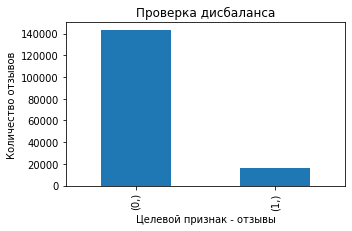

,text,toxic
1321,"""\n\nWhat """"links/content"""" on what page?\n """,0
121222,"Avoiding edit warring \n\nSonicyouth86, we app...",0
87734,Comment. The proposed text is preferable to th...,0
71033,"British Empire Map=\n\nThe map is good, Howeve...",0
129348,"OK, will do. Thanks for unprotecting it. I w...",0


,toxic
count,"159,292.00"
mean,0.10
std,0.30
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,1.00


In [ ]:
research(data, 'исходных данных', 'toxic', silent=False)

In [ ]:
data['text'] = data['text'].values #.astype('U')
data['text'] = data['text'].str.lower()
#data.sample(5)

In [ ]:
research(data, 'исходных данных', 'toxic', silent=True)

Размер данных:      (159292, 2)
Количество явных дубликатов: 45

Проверка структуры исходных данных:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB

Соотношение в целевом признаке:
0   89.84
1   10.16
Name: toxic, dtype: float64


,text,toxic
92222,al-rahma tv is a notable egyptian television s...,0
23788,"em, from the looks of it, you're not being ver...",0
45995,removal of external links per wp:el\nper wp:el...,0
119867,". perhaps the childish feminists of wikipedia,...",0
67580,your edit to the dark crusade section of the d...,0


In [ ]:
#удалим явные дубликаты:
data = data.drop_duplicates()

In [ ]:
research(data, 'исходных данных', 'toxic', silent=True)

Размер данных:      (159247, 2)
Количество явных дубликатов: 0

Проверка структуры исходных данных:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159247 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159247 non-null  object
 1   toxic   159247 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB

Соотношение в целевом признаке:
0   89.85
1   10.15
Name: toxic, dtype: float64


,text,toxic
35588,"i advise bad editor, canvasser and sockpuppet ...",0
18982,"john, you did not cite what is acceptable, onl...",0
102877,this is not your average not-many-people-know-...,0
20621,"""\n\nrelease history\nregiondateformatunited s...",0
58342,you are a pompous fool.,1


Обрезаем случайным образом данные . Сохраняю новые данные в:
- corpus для модели TF-IDF - до 80000 строк
- corpus_bert для BERT - до 1000 строк

In [ ]:
data_size = 80000
data_size_bert = 1000
corpus = data.sample(data_size).reset_index(drop=True)
corpus_bert = data.sample(data_size_bert).reset_index(drop=True)
#ind_data_size = random.sample(list(data.index), data_size)
#corpus = data[data.index.isin(ind_data_size)].reset_index(drop=True)
print(corpus.shape)
print(corpus_bert.shape)

(80000, 2)
(1000, 2)


In [ ]:
# Инициализирую Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
#Создаю функцию РОS-тэгирования слов:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }
    return tag_dict.get(tag, wordnet.NOUN)


#выполним функцию токенизациии и лемматизации массива текстов с учетом РОS-тэгирования и удаления слов:
def lemma_text(corpus):
    corpus = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(corpus) if not w in stopwords.words('english')]
    return ' '.join(corpus)

#def lemma_text(corpus):
#  corpus_new = []
#  for row in corpus:
#    corpus_new.append(' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(row) if not w in stopwords.words('english')]))
#  return corpus_new
#corpus['clean_lemma_text'] = lemma_text(corpus['text'])

In [ ]:
# функция очищения текста
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text= " ".join(clear_text.split())
    return clear_text

In [ ]:
research(corpus, 'рабочей части данных', 'toxic', silent=True)

Размер данных:      (80000, 2)
Количество явных дубликатов: 0

Проверка структуры рабочей части данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    80000 non-null  object
 1   toxic   80000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB

Соотношение в целевом признаке:
0   89.78
1   10.21
Name: toxic, dtype: float64


,text,toxic
75920,i would much rather we were honest about thing...,0
6920,"""do not copy text from the bbc into wikipedia....",0
74192,"michael kimmel is also frequently cited, but h...",0
59168,your ga review \ni saw that you passed lord of...,0
8660,fuck your face \n\ny\n\n76.67.105.188,1


In [ ]:
%%time
#леммализирую тексты постов:
nltk.download('stopwords')
#stopwords.words('english')[:3]
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
tqdm.pandas()
corpus['text'] = corpus['text'].progress_apply(lemma_text)
#corpus['text'] = corpus['text'].apply(lemma_text)
#stopwords=list(set(stopwords.words('english')))
#corpus['text'] = lemma_text(clear_text(corpus['text']))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
100%|██████████| 80000/80000 [25:03<00:00, 53.21it/s] 

CPU times: user 21min 47s, sys: 2min 43s, total: 24min 30s
Wall time: 25min 3s


In [ ]:
# очистим текст
corpus['text'] = corpus['text'].apply(clear_text)
corpus.sample(5)

,text,toxic
70154,click gizmo huggle bless heart encounter error...,0
26737,fact find bit clunky,0
21684,globalise narcissism interest mind totally ope...,0
20944,luka magnotta sha n t revert article n t want ...,0
41566,appropriate word non native speaker english so...,0


### **Вывод:**

1. Загрузила данные:
- пропусков не обнаружено;
- явные дубликаты обрнаружены после того, как привела тексты к нижнему регистру;
- Соотношение в целевом признаке: 9/1 - явный дисбаланс, надо будет сбаллансировать
2. Обработала данные:
- привела все к нижнему регистру;
- удалила явные дубликаты
- работа выполняется в колабе - для дальнейшей возможности обработки данных. построения модели обрежем данные до 25000 случайным образом
- лематизировала и отчистила тексты.

## **Обучение**

In [ ]:
#Разделяю выборки в соотношении 90/10, стратифицирую их:
features = corpus.drop(['toxic'], axis=1)
target = corpus.toxic

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.1,
                                                                              random_state=12345, stratify = target)

#размеры выборок:
for i in [features_train, target_train, features_test, target_test]:
    print(i.shape)
stopwords=list(set(stopwords.words('english')))

(72000, 1)
(72000,)
(8000, 1)
(8000,)


In [ ]:
#Возможно воспользуюсь невекторизованными данными в pipeline
features_train1=features_train.copy
features_test1=features_test.copy

### **2.1. TF-IDF**
- выполним векторизацию слов методом **TfidfVectorize**.
- Методом `fit` настриваем модель, `transform` выполняеем вектризацию.

In [ ]:
#stopwords=list(set(stopwords.words('english')))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features_train = count_tf_idf.fit_transform(features_train['text']) #.values.astype('U')
#features_valid = count_tf_idf.transform(features_valid['text'])
features_test = count_tf_idf.transform(features_test['text'])
cv_counts = 5

**Ресемплирование данных**
уменьшаю кол-во 0 в выборках train:

In [ ]:
#уменьшаю кол-во 0 в выборках train:
corpus_train = corpus.iloc[target_train.index]
target_train_0 = corpus_train[corpus_train['toxic'] == 0]['toxic']
target_train_1 = corpus_train[corpus_train['toxic'] == 1]['toxic']

target_train_0_resample = target_train_0.sample(target_train_1.shape[0], random_state=12345)
target_train_resample = pd.concat([target_train_0_resample, target_train_1])

features_train_resample = corpus.iloc[target_train_resample.index]


features_train_resample, target_train_resample = shuffle(features_train_resample,
                                                         target_train_resample,
                                                         random_state=12345)

#features_train_resample = features_train_resample.text

print('Соотношение 1/0 в тренировочной выборке:')
print(target_train_resample.value_counts(normalize=True))
print()
print(features_train_resample.shape)
print(target_train_resample.shape)
features_train_resample.head()

Соотношение 1/0 в тренировочной выборке:
0   0.50
1   0.50
Name: toxic, dtype: float64

(14710, 2)
(14710,)


,text,toxic
27873,would somebody get clown remove block particip...,0
21233,anybody watch dbz know never do,0
18587,ever reply post wall,0
55652,dp fuck hell think make line every football pa...,1
14510,knowin dah dork,0


Проведем крос-валидацию на логистической регрессии

In [ ]:
def cross_val_model(model, features, target, name_model):#silent
    #if silent:
    #    features_train_resample = count_tf_idf.transform(features['text'])
    model = model
    f1_result = cross_val_score(model, features, target,
                           cv=cv_counts, scoring='f1').mean()

    print(f'На {name_model} F1 =', f1_result)
    return f1_result

In [ ]:
def cross_val_model_res(model, features, target, name_model, silent):#
    if not silent:
        features = count_tf_idf.transform(features['text'])
    model = model
    f1_result = cross_val_score(model, features, target,
                           cv=cv_counts, scoring='f1').mean()
    print(f'На {name_model} F1 =', f1_result)
    return f1_result

In [ ]:
%%time
start = time.time()
f1_train_lr = cross_val_model(LogisticRegression(), features_train, target_train,\
                              'LogisticRegression') #, silent=False


end = time.time()
t_lr_cv1=round(end-start,2)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
На LogisticRegression F1 = 0.6838005191688864


In [ ]:
%%time
#на LR сбаллансированных данных тренировочной выборки
start = time.time()
f1_train_bal_lr = cross_val_model(LogisticRegression(class_weight='balanced'), features_train, target_train, \
                                  'LogisticRegression с сбалансированными данными')


end = time.time()
t_lr_bal_cv1=round(end-start,2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
На LogisticRegression с сбалансированными данными F1 = 0.7392033634585687


In [ ]:
def result_write(model_name,f1,time_fit):  #t,f1_p,
#функция добавляет значения метрики f1 и время настройки модели

  result_corpus.loc[model_name,'F1_predict'] = f1
  result_corpus.loc[model_name,'Time_fit,сек'] = time_fit
  return result_corpus

result_corpus = pd.DataFrame(columns=['F1_predict','Time_fit,сек'])
result_corpus

,F1_predict,"Time_fit,сек"


In [ ]:
result_write('LogisticRegression',f1_train_lr, t_lr_cv1)
result_write('LogisticRegression_balansed', f1_train_bal_lr, t_lr_bal_cv1)
#result_write('LogisticRegression_resampled', f1_train_res_lr, t_lr_res_cv)

,F1_predict,"Time_fit,сек"
LogisticRegression,0.68,191.85
LogisticRegression_balansed,0.74,127.07


### **Вывод:**

- В ходе предподготовки были получены признаки для обучения и разделена выборка на обучающую, валидационную и тестовую.
- Выполнили векторизацию слов методом **TfidfVectorize**.
- На на кросвалидации модели - выявили, что лучшие результаты показали сбаллансированные данные (использовали модель Логистической регрессии).
- Далее будем проводить обучение моделей на  чистых данных (будем применять балансировку в подборе параметров)

### **Непосредственно обучение:**
напишем функции для обучения моделей, используем GridSearchCV

In [ ]:
%%time

def research (model, features, target, param_search, name_model):
    gsearch = GridSearchCV(estimator=model, cv=5, param_grid=param_search, scoring = 'f1')
    gsearch.fit(features_train, target_train)
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    print('F1 = {:.4f}'.format(best_score))
    print('Лучшие гиперпараметры: ', gsearch.best_params_)
    print(f'Лучшие гиперпараметры {name_model}: {best_model}')
    return best_score, best_model    #, best_score

CPU times: user 0 ns, sys: 15 µs, total: 15 µs
Wall time: 17.6 µs


In [ ]:
# Расчет по чистым данным c Pipeline
def research_pipe(model, features, target, param_search, name_model):
    #обучение:
    pipeline = Pipeline([#("vect", TfidfVectorizer(stop_words='english')),
                     (f"{name_model}", model)])
    gsearch = GridSearchCV(pipeline, param_grid=param_search, cv=5, n_jobs=-1, scoring='f1')
    gsearch.fit(features_train, target_train)
    best_model = gsearch.best_estimator_
    best_score = gsearch.best_score_
    print('F1 = {:.4f}'.format(best_score))
    print(f'Лучшие гиперпараметры LR: {best_model}')
    print(f'Лучшие гиперпараметры LR: ', gsearch.best_params_)

    return gsearch.best_score_, best_model

In [ ]:
def predict_result(model, features, target, name_model, name_sample):
    prediction = model.predict(features) #['text']
    f1_result = f1_score(target, prediction)
    #print(f1_result)
    print(f'{name_model}: F1_{name_sample} ={ round(f1_result,4)}')
    return f1_result

**2.1.1. Логистическая регрессия**

In [ ]:
%%time
start = time.time()
param_search_lr = {'random_state' : [12345], 'max_iter': [100], 'solver' : ['sag'],
                'class_weight': ['balanced'], 'C': np.linspace(0.01, 15, 5)
                }#

train_lr_f1, model_lr = research (LogisticRegression(),features_train, target_train,\
                                      param_search_lr, 'LogisticRegression')


end = time.time()
t_lr=round(end-start,2)
print(t_lr)

F1 = 0.7560
Лучшие гиперпараметры:  {'C': 15.0, 'class_weight': 'balanced', 'max_iter': 100, 'random_state': 12345, 'solver': 'sag'}
Лучшие гиперпараметры LogisticRegression: LogisticRegression(C=15.0, class_weight='balanced', random_state=12345,
                   solver='sag')
119.9
CPU times: user 1min 59s, sys: 112 ms, total: 1min 59s
Wall time: 1min 59s


In [ ]:
%%time
start = time.time()
parameters = {'lr__C': (.1, 15, 5),
              'lr__random_state': ([12345]),
              'lr__max_iter': ([20]),
              'lr__class_weight': (['balanced'])}
train_lr_f1_pipe, model_lr_pipe = research_pipe(LogisticRegression(), features_train1, target_train,\
                                                    parameters, 'lr')
end = time.time()
t_catb_res=round(end-start,4)

F1 = 0.7504
Лучшие гиперпараметры LR: Pipeline(steps=[('lr',
                 LogisticRegression(C=15, class_weight='balanced', max_iter=20,
                                    random_state=12345))])
Лучшие гиперпараметры LR:  {'lr__C': 15, 'lr__class_weight': 'balanced', 'lr__max_iter': 20, 'lr__random_state': 12345}
CPU times: user 43.4 s, sys: 1min 34s, total: 2min 17s
Wall time: 2min 18s


In [ ]:
%%time
start = time.time()
f1_lr_cv = cross_val_model(model_lr, features_train, target_train,\
                              'LogisticRegression') #, silent=False


end = time.time()
t_lr_cv=round(end-start,2)

На LogisticRegression F1 = 0.7559519925346023
CPU times: user 26.1 s, sys: 128 ms, total: 26.2 s
Wall time: 26.4 s


**2.1.2. CatBoostClassifier**

In [ ]:
%%time
start = time.time()
parameters = {'iterations': [5],'max_depth': [x for x in range(1, 8)],
              'auto_class_weights': ['Balanced'],'random_state' : [12345],'verbose' : [False]
              }#'task_type':["GPU"],

train_catb_f1, model_catb = research(CatBoostClassifier(), features_train, target_train,\
                                              parameters,'CatBoostClassifier')


end = time.time()
t_catb=round(end-start,2)
print(t_catb)

F1 = 0.6160
Лучшие гиперпараметры:  {'auto_class_weights': 'Balanced', 'iterations': 5, 'max_depth': 6, 'random_state': 12345, 'verbose': False}
Лучшие гиперпараметры CatBoostClassifier: <catboost.core.CatBoostClassifier object at 0x7f8b243410d0>
691.42
CPU times: user 10min 52s, sys: 14 s, total: 11min 6s
Wall time: 11min 31s


In [ ]:
%%time
start = time.time()
parameters = {'catb__iterations': ([5]),
              'catb__random_state': ([12345]),
              'catb__max_depth': ([x for x in range(1, 8)]),
              'catb__class_weights': (['balanced']),
              'catb__verbose' : ([False])}
train_catb_f1_pipe, model_catb_pipe = research_pipe(CatBoostClassifier(), features_train1, target_train,\
                                                    parameters, 'catb')
end = time.time()
t_catb_pipe=round(end-start,4)

F1 = 0.5681
Лучшие гиперпараметры LR: Pipeline(steps=[('catb',
                 <catboost.core.CatBoostClassifier object at 0x7f8a3437b5e0>)])
Лучшие гиперпараметры LR:  {'catb__iterations': 5, 'catb__max_depth': 7, 'catb__random_state': 12345, 'catb__verbose': False}
CPU times: user 9min 41s, sys: 13.3 s, total: 9min 54s
Wall time: 10min 14s


In [ ]:
%%time
start = time.time()
f1_catb_cv = cross_val_model(model_catb, features_train, target_train,\
                              'CatBoostClassifier') #, silent=False


end = time.time()
t_catb_cv=round(end-start,2)

На LogisticRegression F1 = 0.6159854265086198
CPU times: user 1min 41s, sys: 3.03 s, total: 1min 44s
Wall time: 1min 48s


**2.1.3. Случайный лес**

In [ ]:
%%time
start = time.time()
parameters = {'max_depth': [x for x in range(1, 20)],
              'random_state': [12345], 'class_weight': ['balanced'],
              'criterion': ['entropy', 'gini'], 'n_estimators': range (1, 5, 2)
              #'verbose':[False],'task_type':["GPU"],
              }
train_rfc_f1, model_rfc = research(RandomForestClassifier(), features_train, \
                                              target_train, parameters,'RandomForestClassifier()')

end = time.time()
t_rfc=round(end-start,2)
print(t_rfc)

F1 = 0.2785
Лучшие гиперпараметры:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 19, 'n_estimators': 3, 'random_state': 12345}
Лучшие гиперпараметры RandomForestClassifier(): RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=19, n_estimators=3, random_state=12345)
118.08
CPU times: user 1min 49s, sys: 8.28 s, total: 1min 57s
Wall time: 1min 58s


In [ ]:
%%time
start = time.time()
f1_rfc_cv = cross_val_model(model_rfc, features_train, target_train,\
                              'RandomForestClassifier') #, silent=False


end = time.time()
t_rfc_cv=round(end-start,2)

На RandomForestClassifier F1 = 0.27845215447006544
CPU times: user 3.46 s, sys: 78.1 ms, total: 3.54 s
Wall time: 3.54 s


**2.1.4. SGDClassifier**

In [ ]:
%%time
start = time.time()
param_search_sgdc = {'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'loss':['hinge', 'log', 'modified_huber'],
                'random_state' : [12345],
                'eta0': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'class_weight': ['balanced']}

train_sgdc_f1, model_sgdc = research (SGDClassifier(),features_train, target_train, param_search_sgdc, 'SGDClassifier')

end = time.time()
t_sgdc=round(end-start,2)
print(t_sgdc)

F1 = 0.7487
Лучшие гиперпараметры:  {'class_weight': 'balanced', 'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12345}
Лучшие гиперпараметры SGDClassifier: SGDClassifier(class_weight='balanced', eta0=0.1, learning_rate='adaptive',
              loss='modified_huber', random_state=12345)
316.1
CPU times: user 4min 37s, sys: 37.9 s, total: 5min 15s
Wall time: 5min 16s


In [ ]:
%%time
start = time.time()
f1_sgdc_cv = cross_val_model(model_sgdc, features_train, target_train,\
                              'SGDClassifier') #, silent=False


end = time.time()
t_sgdc_cv=round(end-start,2)

На SGDClassifier F1 = 0.7486783142774656
CPU times: user 5.16 s, sys: 659 ms, total: 5.82 s
Wall time: 5.92 s


### **Протестируем лучшую модель:**

In [ ]:
f1_lr = predict_result(model_lr, features_test, target_test, 'LogisticRegression', 'test')

LogisticRegression: F1_test =0.7622


In [ ]:
#f1_sgdc = predict_result(model_sgdc, features_test, target_test, 'SGDClassifier', 'test')

In [ ]:
#f1_catb = predict_result(model_catb, features_test, target_test, 'CatBoostClassifier', 'test')

In [ ]:
#f1_rfc = predict_result(model_rfc, features_test, target_test, 'RandomForestClassifier', 'test')

### **2.2 Обучение на BERT**

Обучение проводила в отдельном файле в Колабе (в силу ограниченности ресурсов)
> все данные занесены в таблицу ниже и в выводах

Ссылка на файл: https://colab.research.google.com/drive/12qs7ow6BDtS1kQR4VawJPtravKGGF0h7?usp=sharing

## Выводы

In [ ]:
#Результаты на BERT
f1_cv_lr = 0.9217   #'LogisticRegression'
f1_cv_sgdc =0.8623  #'SGDClassifier'
f1_cv_rf = 0.9152    #'RandomForestClassifier'
f1_cv_dtc = 0.9152 #'DecisionTreeClassifier'
f1_test_lr = 0.9778
#LogisticRegression	0.9217	0.9778
#SGDClassifier	0.8623	None
#RandomForestClassifier	0.9152	None
#DecisionTreeClassifier	0.9152	None

index = ['LogisticRegression',
         'CatBoostClassifier',
         'RandomForestClassifier',
         'SGDClassifier',]
data = {'F1_Берте на тесте':[f1_test_lr,
                      'None',
                      'None',
                      'None'],
        'F1_TF-IDF на тесте':[f1_lr,
                           'None',#f1_catb
                           'None',#f1_rfc
                           'None'],#f1_sgdc
        'F1_cv на Берте':[f1_cv_lr,
                      0,
                      f1_cv_rf,
                      f1_cv_sgdc],
        'F1_cv на TF-IDF':[f1_lr_cv,
                           f1_catb_cv,
                           f1_rfc_cv,
                           f1_sgdc_cv],
        'Время выполнения на тесте, сек':[t_lr,
                                          t_catb,
                                          t_rfc,
                                          t_sgdc],}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1_cv на Берте'] >= 0.75
scores_data

,F1_Берте на тесте,F1_TF-IDF на тесте,F1_cv на Берте,F1_cv на TF-IDF,"Время выполнения на тесте, сек",Выполнение задачи
LogisticRegression,0.98,0.76,0.92,0.76,119.90,True
CatBoostClassifier,None,None,0.00,0.62,691.42,False
RandomForestClassifier,None,None,0.92,0.28,118.08,True
SGDClassifier,None,None,0.86,0.75,316.10,True


# **Выводы:**
- Загрузила данные:
  - Обнаружила, что соотношение в целевом признаке: 9/1 - явный дисбаланс, при обучении модели учитывала это, поэтому проверяла на применение параметра баллансировки;
- Обработала данные:
  - привела все к нижнему регистру.
  - из-за ограниченности ресурсов - данные обрезала случайным образом.
  - лематизировала и отчистила тексты.
- Выполнила векторизацию слов методом **TfidfVectorize**.
- На на кросвалидации модели - выявили, что лучшие результаты показали ресемплированные данные (использовали модель Логистической регрессии).
- Проводила обучение моделей на ресемплированных и чистых данных (будем применять балансировку в подборе параметров)
- Использовала следующие модели:
   - `LogisticRegression`,
   - `CatBoostClassifier`,
   - `RandomForestClassifier`,
   - `SGDClassifier`
   - Дополнительно провела исследование моделей на **BERT**
- Применили обучение модели методом **BERT**(использовала обученную на определение токсичности)
- По итогу исследований - выявили, что лучше всех себя  показывает модель **Логистической регрессии** (и RandomForestClassifier также с близкими показателями):
  - лучший результат в **f1 = 0.9268** получила при использовании модели **BERT**
  - лучшей моделью на **TF-IDF** оказалась также Логистическая регрессия : **F1_test =0.7622**
  > модель BERT запускала на колабе, использовала выборку в 1000 из-за граниченности ресурсов
Неплохо себя также показала модель  Логистической регресии

